[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-labs/langchain-course/blob/main/chapters/01-intro.ipynb)

#### LangChain Essentials Course

# Getting Started with LangChain

LangChain is one of the most popular open source libraries for AI Engineers. It's goal is to abstract away the complexity in building AI software, provide easy-to-use building blocks, and make it easier when switching between AI service providers.

In this example, we will introduce LangChain, building a simple LLM-powered assistant. We'll provide examples for both OpenAI's `gpt-4o-mini` *and* Meta's `llama3.2` via Ollama!

---

> ⚠️ We will be using OpenAI for this example allowing us to run everything via API. If you would like to use Ollama instead, check out the [Ollama LangChain Course](https://github.com/aurelio-labs/langchain-course/tree/main/notebooks/ollama).

---

In [1]:
!uv add langchain-core

Resolved 95 packages in 3ms
Audited 60 packages in 0.25ms


In [2]:
!uv add langchain-community

Resolved 95 packages in 3ms
Audited 60 packages in 0.34ms


In [3]:
!uv add langchain-google-genai

Resolved 95 packages in 3ms
Audited 60 packages in 0.31ms


In [4]:
!uv add pydantic

Resolved 95 packages in 3ms
Audited 60 packages in 0.26ms


# I will be using Gemini not OpenAI.

## Initializing Gemini's gemini-2.0-flash

- Reference API Docs all the time - [link](https://python.langchain.com/docs/integrations/chat/google_generative_ai/)


In [5]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [6]:
# To enable automated tracing of your model calls, set your LangSmith API key:

# os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
# os.environ["LANGSMITH_TRACING"] = "true"

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

# For normal accurate responses
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)


# For unique creative responses
creative_llm = ChatGoogleGenerativeAI(temperature=0.9, model="gemini-2.0-flash")

We will be taking an `article` _draft_ and using LangChain to generate various useful items around this article. We'll be creating:

1. An article title
2. An article description
3. Editor advice where we will insert an additional paragraph in the article
4. A thumbnail / hero image for our article.

Here we input our article to start with. Currently this is using an article from the Aurelio AI learning page.

In [8]:
article = """
\
We believe AI's short—to mid-term future belongs to agents and that the long-term future of *AGI* may evolve from agentic systems. Our definition of agents covers any neuro-symbolic system in which we merge neural AI (such as an LLM) with semi-traditional software.

With agents, we allow LLMs to integrate with code — allowing AI to search the web, perform math, and essentially integrate into anything we can build with code. It should be clear the scope of use cases is phenomenal where AI can integrate with the broader world of software.

In this introduction to AI agents, we will cover the essential concepts that make them what they are and why that will make them the core of real-world AI in the years to come.

---

## Neuro-Symbolic Systems

Neuro-symbolic systems consist of both neural and symbolic computation, where:

- Neural refers to LLMs, embedding models, or other neural network-based models.
- Symbolic refers to logic containing symbolic logic, such as code.

Both neural and symbolic AI originate from the early philosophical approaches to AI: connectionism (now neural) and symbolism. Symbolic AI is the more traditional AI. Diehard symbolists believed they could achieve true AGI via written rules, ontologies, and other logical functions.

The other camp were the connectionists. Connectionism emerged in 1943 with a theoretical neural circuit but truly kicked off with Rosenblatt's perceptron paper in 1958 [1][2]. Both of these approaches to AI are fascinating but deserve more time than we can give them here, so we will leave further exploration of these concepts for a future chapter.

Most important to us is understanding where symbolic logic outperforms neural-based compute and vice-versa.

| Neural | Symbolic |
| --- | --- |
| Flexible, learned logic that can cover a huge range of potential scenarios. | Mostly hand-written rules which can be very granular and fine-tuned but hard to scale. |
| Hard to interpret why a neural system does what it does. Very difficult or even impossible to predict behavior. | Rules are written and can be understood. When unsure why a particular ouput was produced we can look at the rules / logic to understand. |
| Requires huge amount of data and compute to train state-of-the-art neural models, making it hard to add new abilities or update with new information. | Code is relatively cheap to write, it can be updated with new features easily, and latest information can often be added often instantaneously. |
| When trained on broad datasets can often lack performance when exposed to unique scenarios that are not well represented in the training data. | Easily customized to unique scenarios. |
| Struggles with complex computations such as mathematical operations. | Perform complex computations very quickly and accurately. |

Pure neural architectures struggle with many seemingly simple tasks. For example, an LLM *cannot* provide an accurate answer if we ask it for today's date.

Retrieval Augmented Generation (RAG) is commonly used to provide LLMs with up-to-date knowledge on a particular subject or access to proprietary knowledge.

### Giving LLMs Superpowers

By 2020, it was becoming clear that neural AI systems could not perform tasks symbolic systems typically excelled in, such as arithmetic, accessing structured DB data, or making API calls. These tasks require discrete input parameters that allow us to process them reliably according to strict written logic.

In 2022, researchers at AI21 developed Jurassic-X, an LLM-based "neuro-symbolic architecture." Neuro-symbolic refers to merging the "neural computation" of large language models (LLMs) with more traditional (i.e. symbolic) computation of code.

Jurassic-X used the Modular Reasoning, Knowledge, and Language (MRKL) system [3]. The researchers developed MRKL to solve the limitations of LLMs, namely:

- Lack of up-to-date knowledge, whether that is the latest in AI or something as simple as today's date.
- Lack of proprietary knowledge, such as internal company docs or your calendar bookings.
- Lack of reasoning, i.e. the inability to perform operations that traditional software is good at, like running complex mathematical operations.
- Lack of ability to generalize. Back in 2022, most LLMs had to be fine-tuned to perform well in a specific domain. This problem is still present today but far less prominent as the SotA models generalize much better and, in the case of MRKL, are able to use tools relatively well (although we could certainly take the MRKL solution to improve tool use performance even today).

MRKL represents one of the earliest forms of what we would now call an agent; it is an LLM (neural computation) paired with executable code (symbolic computation).

## ReAct and Tools

There is a misconception in the broader industry that an AI agent is an LLM contained within some looping logic that can generate inputs for and execute code functions. This definition of agents originates from the huge popularity of the ReAct agent framework and the adoption of a similar structure with function/tool calling by LLM providers such as OpenAI, Anthropic, and Ollama.

![ReAct agent flow with the Reasoning-Action loop [4]. When the action chosen specifies to use a normal tool, the tool is used and the observation returned for another iteration through the Reasoning-Action loop. To return a final answer to the user the LLM must choose action "answer" and provide the natural language response, finishing the loop.](/images/posts/ai-agents/ai-agents-00.png)

<small>ReAct agent flow with the Reasoning-Action loop [4]. When the action chosen specifies to use a normal tool, the tool is used and the observation returned for another iteration through the Reasoning-Action loop. To return a final answer to the user the LLM must choose action "answer" and provide the natural language response, finishing the loop.</small>

Our "neuro-symbolic" definition is much broader but certainly does include ReAct agents and LLMs paired with tools. This agent type is the most common for now, so it's worth understanding the basic concept behind it.

The **Re**ason **Act**ion (ReAct) method encourages LLMs to generate iterative *reasoning* and *action* steps. During *reasoning,* the LLM describes what steps are to be taken to answer the user's query. Then, the LLM generates an *action,* which we parse into an input to some executable code, which we typically describe as a tool/function call.

![ReAct method. Each iteration includes a Reasoning step followed by an Action (tool call) step. The Observation is the output from the previous tool call. During the final iteration the agent calls the answer tool, meaning we generate the final answer for the user.](/images/posts/ai-agents/ai-agents-01.png)

<small>ReAct method. Each iteration includes a Reasoning step followed by an Action (tool call) step. The Observation is the output from the previous tool call. During the final iteration the agent calls the answer tool, meaning we generate the final answer for the user.</small>

Following the reason and action steps, our action tool call returns an observation. The logic returns the observation to the LLM, which is then used to generate subsequent reasoning and action steps.

The ReAct loop continues until the LLM has enough information to answer the original input. Once the LLM reaches this state, it calls a special *answer* action with the generated answer for the user.

## Not only LLMs and Tool Calls

LLMs paired with tool calling are powerful but far from the only approach to building agents. Using the definition of neuro-symbolic, we cover architectures such as:

- Multi-agent workflows that involve multiple LLM-tool (or other agent structure) combinations.
- More deterministic workflows where we may have set neural model-tool paths that may fork or merge as the use case requires.
- Embedding models that can detect user intents and decide tool-use or LLM selection-based selection in vector space.

These are just a few high-level examples of alternative agent structures. Far from being designed for niche use cases, we find these alternative options to frequently perform better than the more common ReAct or Tool agents. We will cover all of these examples and more in future chapters.

---

Agents are fundamental to the future of AI, but that doesn't mean we should expect that future to come from agents in their most popular form today. ReAct and Tool agents are great and handle many simple use cases well, but the scope of agents is much broader, and we believe thinking beyond ReAct and Tools is key to building future AI.

---

You can sign up for the [Aurelio AI newsletter](https://b0fcw9ec53w.typeform.com/to/w2BDHVK7) to stay updated on future releases in our comprehensive course on agents.

---

## References

[1] The curious case of Connectionism (2019) [https://www.degruyter.com/document/doi/10.1515/opphil-2019-0018/html](https://www.degruyter.com/document/doi/10.1515/opphil-2019-0018/html)

[2] F. Rosenblatt, [The Perceptron: A Probabilistic Model for Information Storage and Organization in the Brain](https://www.ling.upenn.edu/courses/cogs501/Rosenblatt1958.pdf) (1958), Psychological Review

[3] E. Karpas et al. [MRKL Systems: A Modular, Neuro-Symbolic Architecture That Combines Large Language Models, External Knowledge Sources and Discrete Reasoning](https://arxiv.org/abs/2205.00445) (2022), AI21 Labs
"""

## Preparing our Prompts

LangChain comes with several prompt classes and methods for organizing or constructing our prompts. We will cover these in more detail in later examples, but for now we'll cover the essentials that we need here.

Prompts for chat agents are at a minimum broken up into three components, those are:

- System prompt: this provides the instructions to our LLM on how it must behave, what it's objective is, etc.

- User prompt: this is a user written input.

- AI prompt: this is the AI generated output. When representing a conversation, previous generations will be inserted back into the next prompt and become part of the broader _chat history_.

```
You are a helpful AI assistant, you will do XYZ.    | SYSTEM PROMPT

User: Hi, what is the capital of Australia?         | USER PROMPT
AI: It is Canberra                                  | AI PROMPT
User: When is the best time to visit?               | USER PROMPT
```

LangChain provides us with _templates_ for each of these prompt types. By using templates we can insert different inputs to the template, modifying the prompt based on the provided inputs.

[Reference APi DOCS](https://python.langchain.com/api_reference/core/prompts.html)

Let's initialize our system and user prompt first:


In [9]:
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate

# Defining the system prompt (how the AI should act)
system_prompt = SystemMessagePromptTemplate.from_template(
    "You are an AI assistant that helps generate article titles."
)

# the user prompt is provided by the user, in this case however the only dynamic
# input is the article
user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a name for a article.
The article is here for you to examine {article}

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.""",
    input_variables=["article"]
)

We can display what our formatted human prompt would look like after inserting a value into the `article` parameter:

In [10]:
user_prompt.format(article="TEST STRING")

HumanMessage(content='You are tasked with creating a name for a article.\nThe article is here for you to examine TEST STRING\n\nThe name should be based of the context of the article.\nBe creative, but make sure the names are clear, catchy,\nand relevant to the theme of the article.\n\nOnly output the article name, no other explanation or\ntext can be provided.', additional_kwargs={}, response_metadata={})

In [11]:
print(user_prompt.format(article="TEST STRING").content)

You are tasked with creating a name for a article.
The article is here for you to examine TEST STRING

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.


In [12]:
print(user_prompt.format(article="TEST STRING"))

content='You are tasked with creating a name for a article.\nThe article is here for you to examine TEST STRING\n\nThe name should be based of the context of the article.\nBe creative, but make sure the names are clear, catchy,\nand relevant to the theme of the article.\n\nOnly output the article name, no other explanation or\ntext can be provided.' additional_kwargs={} response_metadata={}


# Always Try to go through documentation , test the things hands-on to get mental clarity over what's happening :)

We have our system and user prompts, we can merge both into our full chat prompt using the `ChatPromptTemplate`:

In [13]:
from langchain.prompts import ChatPromptTemplate

first_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])

By default, the `ChatPromptTemplate` will read the `input_variables` from each of the prompt templates inserted and allow us to use those input variables when formatting the full chat prompt template:

In [14]:
print(first_prompt.format(article="TEST STRING"))

System: You are an AI assistant that helps generate article titles.
Human: You are tasked with creating a name for a article.
The article is here for you to examine TEST STRING

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.


`ChatPromptTemplate` also prefixes each individual message with it's role, ie `System:`, `Human:`, or `AI:`.

We can chain together our `first_prompt` template and the `llm` object we defined earlier to create a simple LLM chain. This chain will perform the steps **prompt formatting > llm generation > get output**.

We'll be using **L**ang**C**hain **E**xpression **L**anguage (LCEL) to construct our chain. This syntax can look a little strange but we will cover it in detail later in the course. For now, all we need to know is that we define our inputs with the first dictionary segment (ie `{"article": lambda x: x["article"]}`) and then we use the pipe operator (`|`) to say that the output from the left of the pipe will be fed into the input to the right of the pipe.

In [15]:
chain_one = (
    {"article": lambda x: x["article"]}
    | first_prompt
    | creative_llm
    | {"article_title": lambda x: x.content}
)

Our first chain creates the article title, note: we can run all of these individually...

In [16]:
article_title_msg = chain_one.invoke({"article": article})
article_title_msg

{'article_title': 'AI Agents: The Neuro-Symbolic Revolution'}

But we will actually chain this step with multiple other `LLMChain` steps. So, to continue, our next step is to summarize the article using both the `article` and newly generated `article_title` values, from which we will output a new `summary` variable:

In [17]:
second_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a description for
the article. The article is here for you to examine:

---

{article}

---

Here is the article title '{article_title}'.

Output the SEO friendly article description. Do not output
anything other than the description.""",
    input_variables=["article", "article_title"]
)

second_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    second_user_prompt
])

In [18]:
chain_two = (
    {
        "article": lambda x: x["article"],
        "article_title": lambda x: x["article_title"]
    }
    | second_prompt
    | llm
    | {"summary": lambda x: x.content}
)

In [19]:
article_description_msg = chain_two.invoke({
    "article": article,
    "article_title": article_title_msg["article_title"]
})
article_description_msg

{'summary': "Explore the rise of AI agents as neuro-symbolic systems, merging neural networks with traditional code. Discover how they're revolutionizing AI, from ReAct frameworks to advanced architectures, and why they're key to unlocking the future of artificial intelligence."}

The third step will consume our first `article` variable and provide several output fields, focusing on helping the user improve a part of their writing. As we are outputting multiple fields we can specify for the LLM to use structured outputs, keeping the generated fields aligned with our requirements.

In [20]:
third_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a new paragraph for the
article. The article is here for you to examine:

---

{article}

---

Choose one paragraph to review and edit. During your edit
ensure you provide constructive feedback to the user so they
can learn where to improve their own writing.""",
    input_variables=["article"]
)

# prompt template 3: creating a new paragraph for the article
third_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    third_user_prompt
])

We create a pydantic object describing the output format we need. This format description is then passed to our model using the `with_structured_output` method:

In [21]:
from pydantic import BaseModel, Field

class Paragraph(BaseModel):
    original_paragraph: str = Field(description="The original paragraph")
    edited_paragraph: str = Field(description="The improved edited paragraph")
    feedback: str = Field(description=(
        "Constructive feedback on the original paragraph"
    ))

structured_llm = creative_llm.with_structured_output(Paragraph)

Now we put all of this together in another chain:

In [22]:
# chain 3: inputs: article / output: article_para
chain_three = (
    {"article": lambda x: x["article"]}
    | third_prompt
    | structured_llm
    | {
        "original_paragraph": lambda x: x.original_paragraph,
        "edited_paragraph": lambda x: x.edited_paragraph,
        "feedback": lambda x: x.feedback
    }
)

In [23]:
out = chain_three.invoke({"article": article})
out

{'original_paragraph': "Agents are fundamental to the future of AI, but that doesn't mean we should expect that future to come from agents in their most popular form today. ReAct and Tool agents are great and handle many simple use cases well, but the scope of agents is much broader, and we believe thinking beyond ReAct and Tools is key to building future AI.",
 'edited_paragraph': "While ReAct and tool-based agents currently dominate the landscape and effectively address numerous straightforward applications, the true potential of agents extends far beyond these popular implementations. To unlock the future of AI, it's crucial to broaden our perspective and explore innovative agent architectures that transcend the limitations of ReAct and tool-centric approaches.",
 'feedback': 'The revised paragraph enhances clarity and impact by emphasizing the limitations of current popular agent implementations and highlighting the necessity of exploring more innovative architectures to unlock the

Now we want this article to look appealing, so we need to grab an image based of our article! However the prompt for the article image `cannot be over 1000 letters` so this has to be short in case we want to add anything in such as `style` later on.

## Since i'm using google_api_key , i would like to make use of image generation models provided by google vertex ai.(ignoring for now)

- LangChain provides specific tools for Imagen through langchain_google_vertexai.vision_models: `VertexAIImageGeneratorChat`: For generating novel images from a text prompt (text-to-image). Is what we need to replace openai - DalleEAPIWrapper.
- Reference doc of g[oogle-vertax-ai](https://python.langchain.com/api_reference/google_vertexai/index.html) & [vision models](https://python.langchain.com/api_reference/google_vertexai/vision_models.html)


First Install the library `langchain-google-vertexai` & You need to enable needed Google Cloud APIs (depending on the integration you’re using) and set up credentials by either:
Have credentials configured for your environment
(gcloud, workload identity, etc…)

Store the path to a service account JSON file as the
GOOGLE_APPLICATION_CREDENTIALS environment variable

This codebase uses the google.auth library which first looks for the application credentials variable mentioned above, and then looks for system-level auth.

In [24]:
!uv add langchain-google-vertexai

Resolved 112 packages in 1.02s
Prepared 17 packages in 3.72s
Installed 17 packages in 1.05s
 + bottleneck==1.5.0
 + docstring-parser==0.16
 + google-cloud-aiplatform==1.97.0
 + google-cloud-bigquery==3.34.0
 + google-cloud-core==2.4.3
 + google-cloud-resource-manager==1.14.2
 + google-cloud-storage==2.19.0
 + google-crc32c==1.7.1
 + google-genai==1.20.0
 + google-resumable-media==2.7.2
 + grpc-google-iam-v1==0.14.2
 + langchain-google-vertexai==2.0.25
 + numexpr==2.11.0
 + pyarrow==19.0.1
 + shapely==2.1.1
 + validators==0.35.0
 + websockets==15.0.1


In [26]:
# from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
from langchain_core.prompts import PromptTemplate

image_prompt = PromptTemplate(
    input_variables=["article"],
    template=(
        "Generate a prompt with less then 500 characters to generate an image "
        "based on the following article: {article}"
    )
)

[Generate images using Gemini](https://ai.google.dev/gemini-api/docs/image-generation#gemini)
- Gemini can generate and process images conversationally. You can prompt Gemini with text, images, or a combination of both to achieve various image-related tasks, such as image generation and editing.

You must include responseModalities: ["TEXT", "IMAGE"] in your configuration. Image-only output is not supported with these models.


In [ ]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO
import base64

client = genai.Client()


The `generate_and_display` function will generate the article image once we have the prompt from our image prompt.

In [43]:
from skimage import io
# import matplotlib.pyplot as plt
from langchain_core.runnables import RunnableLambda


def generate_and_display_image(image_prompt):
    # image_url = DallEAPIWrapper().run(image_prompt)
    contents = image_prompt.format(article=article)
    response = client.models.generate_content(
        model="gemini-2.0-flash-preview-image-generation",
        contents=contents,
        config=types.GenerateContentConfig(response_modalities=["TEXT", "IMAGE"]),
    )
    for part in response.candidates[0].content.parts:
        if part.text is not None:
            print(part.text)
        elif part.inline_data is not None:
            image = Image.open(BytesIO((part.inline_data.data)))
            image.save("gemini-native-image.png")
            image.show()


# we wrap this in a RunnableLambda for use with LCEL
image_gen_runnable = RunnableLambda(generate_and_display_image)

We have all of our image generation components ready, we chain them together again with LCEL:

In [44]:
# chain 4: inputs: article, article_para / outputs: new_suggestion_article
chain_four = (
    {"article": lambda x: x["article"]}
    | image_prompt
    | llm
    | (lambda x: x.content)
    | image_gen_runnable
)

And now, we `invoke` our final chain:

In [45]:
chain_four.invoke({"article": article})

I will generate an image depicting an AI agent's brain. The brain will have a glowing, futuristic aesthetic, with visible neural network connections. These connections will extend and intertwine with lines of vibrant, colorful computer code, symbolizing the fusion of neural networks and programming. The overall style will be modern and visually striking.



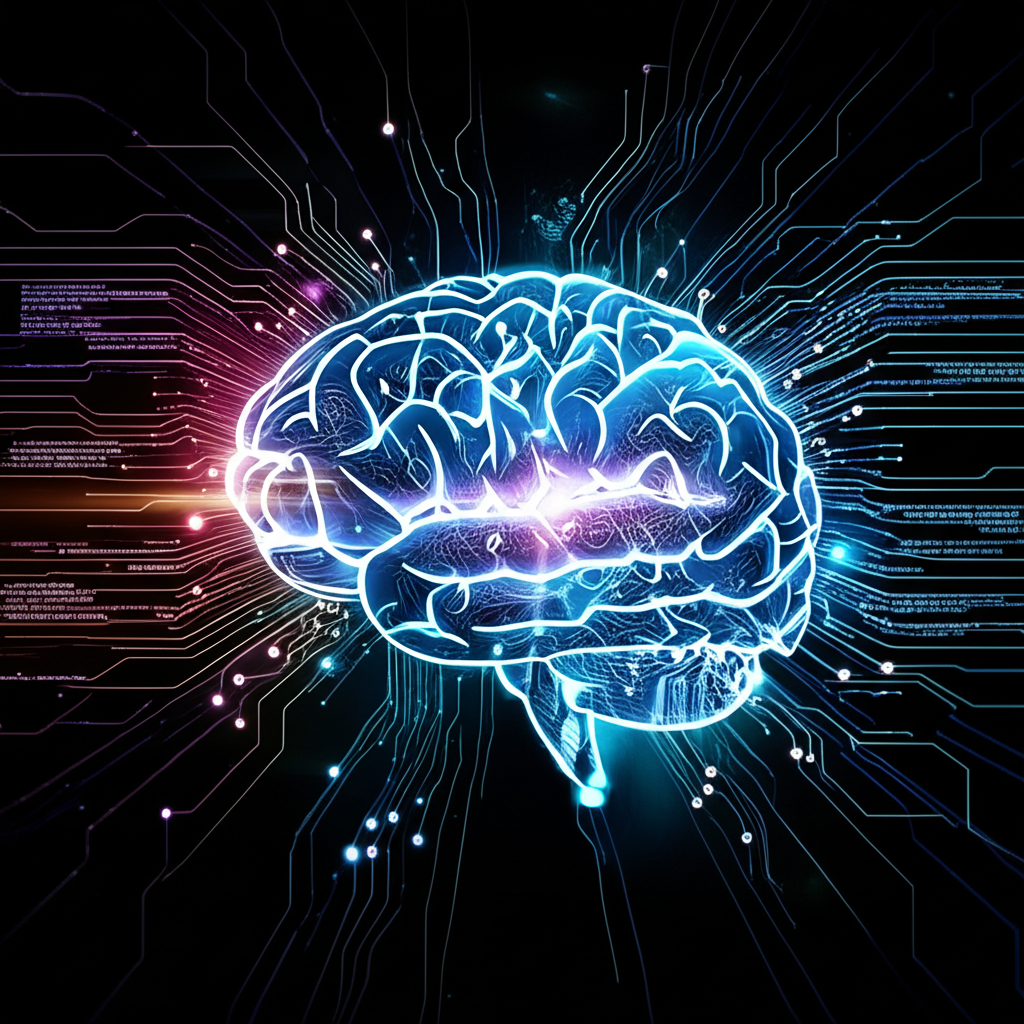

With that we've built LLM chains that can help us building and writing articles. We've understood a few of the basics of LangChain, introduced **L**ang**C**hain **E**xpression **L**anguage (LCEL), and built a multi-modal article-helper pipeline.

# this is great understanding & exploring API's sdk's lol